In [1]:
import polars as pl
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense
import helpers.input_processor as ip
import tqdm
import tensorflow as tf
from tensorflow.data import Dataset as tfds
import tensorflow_io as tfio
import math, random
import numpy as np

from matplotlib import pyplot as plt
import tensorflow.python.util as util

2022-07-26 11:38:36.885364: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import torch
import torchaudio
import polars as pl
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm
from torchaudio import transforms
from IPython.display import Audio
import math, random

import helpers.input_processor as ip

/home/tiaan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# audio_path = path to audio file
# samp_rate = sample rate of the signal
# duration = length of time (in seconds) to which the signal is resized
# do_augmentation = whether to perform audio and image augmentation on the signal
# n_freq_masks = number of frequency masks
# n_time_masks = number of time masks
# n_mels = number of frequency bands (ie. Mel bins)
# **kwargs = keyword arguments passed to transforms.MelSpectrogram()
def preprocessAudio(audio_path, samp_rate=4000, duration=25, do_augmentation=True, n_freq_masks=1, n_time_masks=1, n_mels=128, **kwargs):
    # read and load audio file in .wav format
    sig, sr = torchaudio.load(audio_path, normalize=True)
    sr = samp_rate

    # Check that audio is mono (has 1 audio channel)
    num_channels = sig.shape[0]
    if num_channels != 1:
        raise Exception('The provided audio file \'%s\' has %s channels, when 1 was expected' % (x, num_channels))
    
    # resize sample, either by padding it with silence or truncating it
    num_rows, sig_len = sig.shape
    max_len = sr * duration
    if (sig_len > max_len):
        # Truncate the signal to the given length
        start = random.randint(0, sig_len - max_len)
        sig = sig[:, start : start + max_len]
    elif (sig_len < max_len):
        # Pad with zeroes at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))
        sig = torch.cat((pad_begin, sig, pad_end), 1)

    # Audio Augmentation    --------\
    if do_augmentation == True:
        # time shift signal to the left or right by a random percent of its original length (max 99%)
        _, sig_len = sig.shape
        max_shift = 0.99
        sig = sig.roll(int(random.random() * max_shift * sig_len))
    #-------------------------------/

    # get Mel spectrogram
    top_db = 80
    melSpec = torchaudio.transforms.MelSpectrogram(sr, n_mels=n_mels, normalized=True, **kwargs)(sig)
    melSpec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(melSpec)

    # Image Augmentation    --------\
    if do_augmentation == True:
        # Apply time and frequency mask
        max_mask_pct=0.1
        n_steps = melSpec.shape[2]
        mask_value = melSpec.mean()
        for i in range(n_freq_masks):
            melSpec = torchaudio.transforms.FrequencyMasking(max_mask_pct * n_mels)(melSpec, mask_value)
        for i in range(n_time_masks):
            melSpec = torchaudio.transforms.TimeMasking(max_mask_pct * n_steps)(melSpec, mask_value)
    #-------------------------------/

    out = melSpec.numpy()
    e3, e2, e1 = out.shape
    out = out.reshape(e2,e1)
    
    return out

# function that wraps preprocessAudio() so that it can be passed as the preProcessor function when creating a DataGenerator object
def wrap_preprocessAudio(audio_path):
    return preprocessAudio(audio_path, duration=20)

In [4]:
def splitDataframe(df, split_ratio=0.8):
    total_size = df.height
    train_size = round(split_ratio * total_size)
    test_size = total_size - train_size

    df = df.sample(frac=1.0, shuffle=True)
    trainSet = df.head(train_size)
    testSet = df.tail(test_size)
    return trainSet, testSet

In [5]:
import numpy as np
import keras, keras.utils

class DataGenerator(keras.utils.Sequence):
    # data is represented as a sequence of batches
    # preProcessor = function that takes path to audio file as input and returns numpy array storing signal to be inputted to model
    def __init__(self, audioPaths, labels, preProcessor, batchSize = 32, shuffle=True):
        self.audioPaths = audioPaths
        self.labels = labels
        self.preProcessor = preProcessor
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.classes = np.unique(self.labels)
        self.numClasses = len(self.classes)
        self.on_epoch_end()

    def __len__(self):
        # Get total number of batches
        return int(np.floor(len(self.audioPaths) / self.batchSize))

    def __getitem__(self, index):
        # Get the batch at position 'index'
        batch = self.batches[index]
        # Apply preprocessing function to audio file paths and get the labels
        X = np.array([self.preProcessor(self.audioPaths[x]) for x in batch])
        Y = np.array([self.labels[x] for x in batch])
        return X, Y

    def on_epoch_end(self):
        # Get array of indices used to access data
        dataIndices = np.arange(len(self)*self.batchSize)
        if self.shuffle == True:
            np.random.shuffle(dataIndices)
        # Reshape into an array of batches, where each batch is an array of indices used to access data
        self.batches = np.reshape(dataIndices, (len(self), self.batchSize))


In [6]:
#load data from dataframe
data_dir = "data/raw_training/training_data/"
target_label = 'murmur_in_recording'
df = (
    ip.loadTrainingData(data_dir)
    .filter(pl.col(target_label) != 'Unknown')
    .pipe(ip.encodeData)
    .select([
        pl.col('audio_file').apply(lambda x: os.path.join(data_dir, x)),
        pl.col(target_label)
    ])
)

loading data from save file:  cache/ingested_data.json


In [7]:
#balance the data so that there is an equal number of murmur positive and murmur negative samples
#do this by duplicating random rows of whichever group (pos or neg) is smaller
neg_df = df.filter(pl.col(target_label)==0.0)
pos_df = df.filter(pl.col(target_label)==1.0)
numNeg = neg_df.height
numPos = pos_df.height

while numNeg != numPos:
    if numNeg < numPos:
        df.vstack(neg_df.sample(n=min(numPos-numNeg, neg_df.height), shuffle=True), in_place=True)
    else: 
        df.vstack(pos_df.sample(n=min(numNeg-numPos, pos_df.height), shuffle=True), in_place=True)
    numNeg = df.filter(pl.col(target_label)==0.0).height
    numPos = df.filter(pl.col(target_label)==1.0).height

#reshuffle rows
df = df.sample(frac=1.0, shuffle=True)

#check number of positive and negative samples
numNeg = df.filter(pl.col(target_label)==0.0).height
numPos = df.filter(pl.col(target_label)==1.0).height
print('Total Samples:       ', df.height)
print('Positive Samples:    ', numPos)
print('Negative Samples:    ', numNeg)
print('Percent Positive Samples:    ', numPos/(numPos+numNeg))


# method 2:

# #balance the data so that there is an equal number of murmur positive and murmur negative samples
# #do this by duplicating random rows of whichever group (pos or neg) is smaller
# neg_df = df.filter(pl.col(target_label)==0.0)
# pos_df = df.filter(pl.col(target_label)==1.0)
# numNeg = neg_df.height
# numPos = pos_df.height

# if numNeg < numPos:
#     df = neg_df.vstack(pos_df.sample(n=numNeg))
# elif numPos < numNeg:
#     df = pos_df.vstack(neg_df.sample(n=numPos))
# else:
#     df = neg_df.vstack(pos_df)

# #reshuffle rows
# df = df.sample(frac=1.0, shuffle=True)

# #check number of positive and negative samples
# numNeg = df.filter(pl.col(target_label)==0.0).height
# numPos = df.filter(pl.col(target_label)==1.0).height
# print('Total Samples:       ', df.height)
# print('Positive Samples:    ', numPos)
# print('Negative Samples:    ', numNeg)
# print('Percent Positive Samples:    ', numPos/(numPos+numNeg))

Total Samples:        5328
Positive Samples:     2664
Negative Samples:     2664
Percent Positive Samples:     0.5


In [8]:
#duplicate dataframe to get more data
df = df.vstack(df.select(pl.all()))

train_df, test_df = splitDataframe(df, split_ratio=0.8)
# train_df, val_df = splitDataframe(train_df, split_ratio=0.7/0.8)
classes = df.get_column(target_label).unique().to_list()

batch_size = 64
preProcessor = wrap_preprocessAudio

train_gen = DataGenerator(
    audioPaths=train_df.get_column('audio_file').to_list(),
    labels=train_df.get_column(target_label).to_list(),
    preProcessor=preProcessor,
    batchSize=batch_size
)
test_gen = DataGenerator(
    audioPaths=test_df.get_column('audio_file').to_list(),
    labels=test_df.get_column(target_label).to_list(),
    preProcessor=preProcessor,
    batchSize=batch_size
)
# val_gen = DataGenerator(
#     audioPaths=val_df.get_column('audio_file').to_list(),
#     labels=val_df.get_column(target_label).to_list(),
#     preProcessor=preProcessor,
#     batchSize=batch_size
# )


In [9]:
#keras script

import numpy as np

from keras.models import Sequential
from tensorflow.keras import datasets, layers, models


examplePath = os.path.join(data_dir, '85349_TV.wav')
example = preProcessor(examplePath)
h, w = example.shape

# Design model
model = Sequential()

# Arcitecture
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(h, w, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['accuracy'])

# Train model on dataset
history = model.fit(x=train_gen, validation_data=test_gen, workers=8, epochs=25)

2022-07-26 11:38:39.834667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 11:38:40.391648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


Epoch 1/25


2022-07-26 11:38:45.496811: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-26 11:38:46.127469: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


133/133 [==============================] - 51s 343ms/step - loss: 28.9886 - accuracy: 0.6095 - val_loss: 0.5954 - val_accuracy: 0.6804
Epoch 2/25
133/133 [==============================] - 48s 344ms/step - loss: 0.5863 - accuracy: 0.6768 - val_loss: 0.5516 - val_accuracy: 0.7154
Epoch 3/25
133/133 [==============================] - 47s 343ms/step - loss: 0.5584 - accuracy: 0.7008 - val_loss: 0.5322 - val_accuracy: 0.7296
Epoch 4/25
133/133 [==============================] - 48s 343ms/step - loss: 0.5377 - accuracy: 0.7180 - val_loss: 0.5584 - val_accuracy: 0.7150
Epoch 5/25
133/133 [==============================] - 56s 409ms/step - loss: 0.5170 - accuracy: 0.7277 - val_loss: 0.5562 - val_accuracy: 0.7150
Epoch 6/25
133/133 [==============================] - 47s 342ms/step - loss: 0.5064 - accuracy: 0.7413 - val_loss: 0.5145 - val_accuracy: 0.7405
Epoch 7/25
133/133 [==============================] - 48s 345ms/step - loss: 0.4991 - accuracy: 0.7499 - val_loss: 0.4850 - val_accuracy: 0.

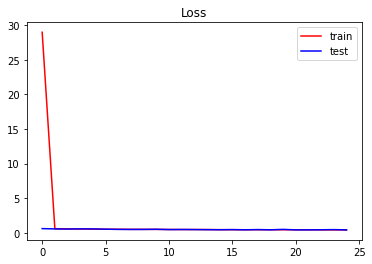

In [10]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train', color='red')
plt.plot(history.history['val_loss'], label='test', color='blue')
plt.legend()
plt.show()

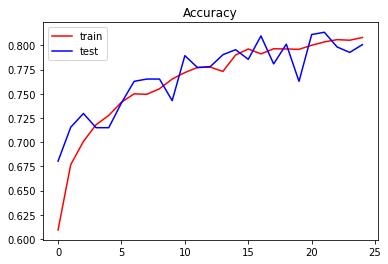

In [11]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train', color='red')
plt.plot(history.history['val_accuracy'], label='test', color='blue')
plt.legend()
plt.show()